In [1]:
%matplotlib inline
# data preparation imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest
from collections import Counter
import re
import sklearn as sk
import math
from sklearn.model_selection import train_test_split

# TODO: cleanup imports
from keras.models import Model
from keras.layers import Dense, Input, Dropout, GlobalMaxPool1D
from keras.layers import merge, Lambda, concatenate, BatchNormalization, Reshape
from keras.layers import TimeDistributed, LSTM
from keras.optimizers import RMSprop
import keras.backend as K
import tensorflow as tf
import keras.callbacks

import os
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

Using TensorFlow backend.


In [2]:
# import x for training, the sentences
with open('./data/xtrain.txt') as f:
    text = f.read()

In [3]:
# process data to remove empty line
xdata = text.split('\n')
xdata = filter(None, xdata)
xdata = np.asarray(xdata)

In [4]:
# import y for training, the ground truth labels
with open('./data/ytrain.txt') as f:
    labeltext = f.read()

In [5]:
# preprocess y to remove emtpy string and convert to integers for checks
ydata_str = labeltext.split('\n')
ydata_str = filter(None, ydata_str) 

ydata = [int(numeric_string) for numeric_string in ydata_str]

In [6]:
# verify that both x and y have the same number of entries
print "Checking if the number of sentences and labels is equal:", len(xdata)==len(ydata)

Checking if the number of sentences and labels is equal: True


In [7]:
# manually load the list of book titles for nicer prints
# I fixed a minor spelling error in one of the book titles here
book_titles = ['alice_in_wonderland','dracula','dubliners','great_expectations','hard_times','huckleberry_finn',
               'les_miserable','moby_dick','oliver_twist','peter_pan','tale_of_two_cities','tom_sawyer']

In [8]:
## Sanity check for labels
# let's take a look at the labels first
# it makes sense to take a look at the labels 
# I like histograms since it's important to check how our labels are distributed 
bins = range(13)
hist, bin_edges = np.histogram(ydata, bins, density=True)

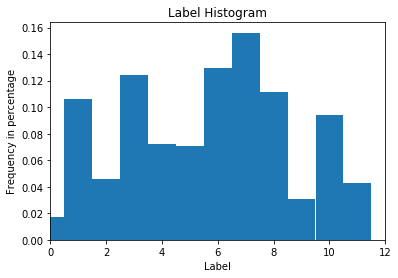

In [9]:
# shows a nice plot of the histogram of labels
plt.title("Label Histogram")
plt.xlabel("Label")
plt.ylabel("Frequency in percentage")
plt.bar(bin_edges[:-1], hist, width=1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()  

# we see in this plot that there is actually not an even distribution of labels

In [10]:
# print a few interesting numbers about the histogram
print ("The book %s, with index %i, has the lowest number of samples, %f percent."
%(book_titles[np.argmin(hist)],np.argmin(hist),min(hist)*100) )
print ("The book %s, with index %i, has the highest number of samples, %f percent."
%(book_titles[np.argmax(hist)],np.argmax(hist),max(hist)*100) )

print ("That means that we have about %i times more samples from %s than from %s."
%(max(hist)/min(hist),book_titles[np.argmax(hist)],book_titles[np.argmin(hist)]) )

The book alice_in_wonderland, with index 0, has the lowest number of samples, 1.704754 percent.
The book moby_dick, with index 7, has the highest number of samples, 15.614689 percent.
That means that we have about 9 times more samples from moby_dick than from alice_in_wonderland.


In [11]:
# I've done a few training test runs and realized that the number of labels is screwed so badly that the prediction
# didn't work well. For example I obtained this histogram of predicted labels for the test data:
# [   0  252    0   72    0    0 2063  434  179    0    0    0] 
# so some classes were not predicted at all, while only the most common 5 classes were predicted
# labels_dict : {ind_label: count_label}

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [12]:
## Clean up sentences
# Some early experiments showed that there were some non-ascii characters in the sentence data
# I've decided to remove these
uni_x = [sen.encode('ascii', 'ignore') for sen in xdata]

In [13]:
## Sanity check for sentences x
x_len = [len(sen) for sen in uni_x]
min_len = min(x_len)
max_len = max(x_len)
print "The longest sentence in the training data has %i symbols, while the shortest has %i symbols."%(max_len,min_len)
print("The average sentence length is %f and the standard deviation is %f."% (np.mean(x_len),np.std(x_len)))

# so the length of the sentences varies but not that much, especially the very short sentences seem to be outliers

The longest sentence in the training data has 189 symbols, while the shortest has 54 symbols.
The average sentence length is 167.874404 and the standard deviation is 8.061963.


[   1    0    0    0    0    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    2    1    0    0
    0    0    0    0    0    0    1    0    0    0    1    0    1    0    0
    0    0    0    0    0    0    0    1    0    1    1    0    0    0    0
    2    5    0    1    4    3    3    1    2    4    2    4    5    6    6
   11   10    6   13   19   18   15   33   23   18   38   43   40   49   64
   58   76   90   92  143  144  158  194  196  260  280  313  346  410  430
  480  577  645  791  914 1083 1259 1476 1760 1893 2122 2245 2245 2212 2029
 1783 1584 1239  904  688  469  286  196   80   59   29   19    8    6]


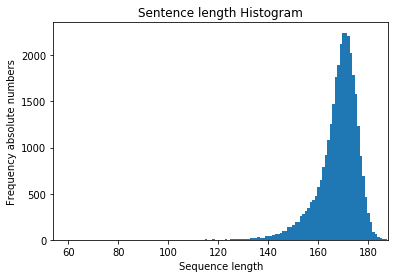

In [14]:
bins = range(min_len,max_len,1)
hist, bin_edges = np.histogram(x_len,bins,density=False )
print hist

# shows a nice plot of the histogram of sentence lengths
plt.title("Sentence length Histogram")
plt.xlabel("Sequence length")
plt.ylabel("Frequency absolute numbers")
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()  

# we see in this plot that the sentence length appears to be normally distributed

In [15]:
print("statistical test for: p value for normality = %f ."%(normaltest(x_len)[1]) )

# theory that the data was picked with normally distributed sentence length can't be rejected

statistical test for: p value for normality = 0.000000 .


In [16]:
def histogram_letters(L):
    d = Counter(letter for line in L for letter in line)
    for letter in d:
        print('{} | {}'.format(letter, d[letter]))
    return d

In [17]:
## histogram of the letters
l_hist = histogram_letters(uni_x)

! | 6720
# | 3
" | 4520
$ | 3
' | 10332
& | 15
) | 804
( | 833
* | 48
- | 19931
, | 108481
/ | 3
. | 50053
1 | 364
0 | 223
3 | 113
2 | 159
5 | 123
4 | 73
7 | 96
6 | 48
9 | 64
8 | 159
; | 15494
: | 2440
= | 11
< | 6
? | 4670
> | 6
[ | 116
] | 103
_ | 3365
a | 428514
c | 118709
b | 83080
e | 651182
d | 242642
g | 112092
f | 112291
i | 357560
h | 353582
k | 46716
j | 8225
m | 135069
l | 211696
o | 402570
n | 364930
q | 5371
p | 85532
s | 327557
r | 293094
u | 147819
t | 484089
w | 134334
v | 46785
y | 103313
x | 6212
{ | 4
z | 2515
} | 3


In [18]:
## analysis
# 'e', 't' and 'a' are most common letters, which was expectable for a dataset using English language text
# I've decided to include punctuation in my model since it could give interesting clues about the novel (or author)
# however I've also decided to ignore some rare symbols - less than 100 occurences
# the alphabet to consider doesn't include these symbols
alphabet = []

for letter in l_hist:
    if l_hist[letter]>=100:
        alphabet = np.append(alphabet, letter)

print("For embedding the sentences, we will use an alphabet with %i letters with at least 100 occurences in the training set."
%len(alphabet))

For embedding the sentences, we will use an alphabet with 46 letters with at least 100 occurences in the training set.


In [19]:
enumeration = dict(enumerate(alphabet,1))
alphabet_dict = dict (zip(enumeration.values(),enumeration.keys()))

print alphabet_dict
            
X = np.ones((len(uni_x), max_len), dtype=np.int64) *-1

for i, sentence in enumerate(uni_x):
    for j, char in enumerate(sentence):
        if char in alphabet:
            X[i,j] = alphabet_dict[char]
            
# Note: this code leaves rare symbols as -1, which is also used for padding the sentences

{'!': 1, '"': 2, "'": 3, ')': 4, '(': 5, '-': 6, ',': 7, '.': 8, '1': 9, '0': 10, '3': 11, '2': 12, '5': 13, '8': 14, ';': 15, ':': 16, '?': 17, '[': 18, ']': 19, '_': 20, 'a': 21, 'c': 22, 'b': 23, 'e': 24, 'd': 25, 'g': 26, 'f': 27, 'i': 28, 'h': 29, 'k': 30, 'j': 31, 'm': 32, 'l': 33, 'o': 34, 'n': 35, 'q': 36, 'p': 37, 's': 38, 'r': 39, 'u': 40, 't': 41, 'w': 42, 'v': 43, 'y': 44, 'x': 45, 'z': 46}


In [20]:
## loading and preparing of test data 
with open('./data/xtest.txt') as f:
    text = f.read()
    
test_data = text.split('\n')
test_data = filter(None, test_data)
test_data = np.asarray(test_data)
uni_test = [sen.encode('ascii', 'ignore') for sen in test_data]

test_len = [len(sen) for sen in uni_test]
min_len = min(test_len)
max_len_test = max(test_len)
print "The longest sentence in the test data has %i symbols, while the shortest has %i symbols."%(max_len_test,min_len)
print("The average sentence length is %f and the standard deviation is %f."% (np.mean(test_len),np.std(test_len)))

# I'm using the same alphabet as extracted from the training data and the maximum length of the training sentences
X_test = np.ones((len(uni_test), np.shape(X)[1]), dtype=np.int64) *-1

# we cut the sentences of the test set off since we use the maximum length of the training sentences
for i, sentence in enumerate(uni_test):
    for j, char in enumerate(sentence):
        if char in alphabet and j < len(uni_x):
            X_test[i,j] = alphabet_dict[char]
            


The longest sentence in the test data has 185 symbols, while the shortest has 87 symbols.
The average sentence length is 168.027000 and the standard deviation is 8.201480.


In [21]:
## one-hot encoding
# we have to embedd our characters so that we can use them as numerical vectors

# technically also other embeddings are available such as char2vec but since of the time constraint, I decided to use one-hot
# I think a better embedding could lead to a significantly better model

# a depth of 64 should be enough since there are 46 characters in this challenge
p_depth = 64

# defining this function to call it on the fly
def transform_one_hot(x, p_depth=64):
    return tf.to_float(tf.one_hot(x, p_depth, on_value=1, off_value=0, axis=-1))

def one_hot_outshape(in_shape):
    return in_shape[0], in_shape[1], p_depth

In [22]:
## data split for validation

# split into training and validation from train.txt
X_train, X_val, y_train, y_val = train_test_split(X, ydata, test_size=0.05, random_state=0)
# since our dataset is already pretty small, we can only afford to have a very small validation set

# X_test is kept intact for predictions

In [23]:
## resampling
# the bias in our data was so big that I decided to resample the training data
# this function outputs a binary index vector which samples should be kept for training

# sampling ratio can be technically any number but should be greater or equal to 1
def sampling_train(y_tr, sampling_ratio=1.0):
    bins = range(13)
    hist, bin_edges = np.histogram(y_tr, bins, density=False)
    # how many samples to take per class - relative to smallest class
    n_samples = int(np.min(hist) * sampling_ratio)
    
    for label in range(len(book_titles)):
        idx = np.where(np.equal(y_tr,label))
        idx = idx[0]
        #shuffle labels
        np.random.shuffle(idx)
        if n_samples < hist[label]:
            idx = idx[:n_samples]
        if label == 0:
            indices = idx
        else:
            indices = np.concatenate((indices,idx),axis=0)
    np.random.shuffle(indices)
    return indices


In [24]:
## model design
# character-level LSTM, for details please see the model explanation file

In [25]:
## (hyper-)parameters
# definition of hyperparameters relevant to this task

# dropout rate for regularization
p_dropout = 0.1

lstm_h = 100

# Load checkpoint if exists
checkpoint = False
# check if grid search is wanted
grid_search = False

In [26]:
## The main model in keras
# insert the input sentence and embedd to one-hot space on-the-fly
in_sentence = Input(shape=(max_len,), dtype='int64')
embedded = Lambda(transform_one_hot, output_shape=one_hot_outshape)(in_sentence)

lstm_layer = LSTM(lstm_h, return_sequences=True, dropout=p_dropout, recurrent_dropout=0.2, implementation=0)(embedded)
lstm_layer2 = LSTM(lstm_h, return_sequences=False, dropout=p_dropout, recurrent_dropout=0.2, implementation=0)(lstm_layer)

# added fully connected layer
feature_vec = Dropout(p_dropout)(lstm_layer2)
feature_vec = Dense(128, activation='relu', kernel_initializer='glorot_normal')(feature_vec)

# apply dropout for regularization
to_out = Dropout(p_dropout)(feature_vec)

# output = Dropout(0.2)(bi_lstm)
output = Dense(12, activation='softmax', kernel_initializer='lecun_uniform')(to_out)

model = Model(outputs=output, inputs=in_sentence)
model.summary()
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 189)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 189, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 189, 100)          66000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [27]:
if checkpoint:
    model.load_weights(checkpoint_dir)

file_name = 'char-level-cnn'
check_cb = keras.callbacks.ModelCheckpoint('checkpoints/' + file_name + '.{epoch:02d}-{val_loss:.2f}.hdf5',
                                            monitor='val_loss',
                                            verbose=0, save_best_only=True, mode='min')

earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

# TODO: set learning rate decay
optimizer = RMSprop(lr=0.001, decay=0.0001)
# using loss for multiclass problem
# combination of categorical_crossentropy and softmax good for multiclass label problem

In [28]:
# following the keras documentation, I've realized that the labels have to be formatted this way in order to use
# the categorical cross entropy loss

y_val = keras.utils.to_categorical(y_val, 12)
#X_val = X_val.reshape(len(X_val), 1, max_len) 

In [29]:
# the actual training is done here
keys = range(0,len(book_titles))
bins = range(13)
    
mu = 0.3
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #class_weights = create_class_weight(labels_dict,mu)
for i in range(15):
    # with this split, it's using about half the training samples
    indices = sampling_train(y_train,1.2)
        
    X_sampled = X_train[indices,:]
    y_sampled = [y_train[j] for j in indices]
        
    hist, bin_edges = np.histogram(y_sampled, bins, density=False)
        
    y_sampled = keras.utils.to_categorical(y_sampled, 12)
    #X_sampled = X_sampled.reshape(len(X_sampled), 1, max_len)    
       
    labels_dict = dict((keys[i],hist[i]) for i in range(len(book_titles)))
    class_weights = create_class_weight(labels_dict,mu)
        
    # class_weight=class_weights,
    model.fit(X_sampled, y_sampled, validation_data=(X_val, y_val), batch_size=32, epochs=5, shuffle=True, callbacks=[check_cb, earlystop_cb])
score = model.evaluate(X_val, y_val, verbose=0)
print("Test loss: %f,  Test accuracy: %f   ,mu  %f" % (score[0],score[1],mu))

Train on 7550 samples, validate on 1637 samples
Epoch 1/5
7550/7550 [==============================] - 70s - loss: 2.4804 - acc: 0.0893 - val_loss: 2.4179 - val_acc: 0.1411
Epoch 2/5
7550/7550 [==============================] - 70s - loss: 2.4549 - acc: 0.1142 - val_loss: 2.4065 - val_acc: 0.1472
Epoch 3/5
7550/7550 [==============================] - 71s - loss: 2.4466 - acc: 0.1241 - val_loss: 2.4698 - val_acc: 0.1069
Epoch 4/5
7550/7550 [==============================] - 71s - loss: 2.4418 - acc: 0.1264 - val_loss: 2.4285 - val_acc: 0.1069
Epoch 5/5
7550/7550 [==============================] - 73s - loss: 2.4378 - acc: 0.1258 - val_loss: 2.4481 - val_acc: 0.1423
Train on 7550 samples, validate on 1637 samples
Epoch 1/5
7550/7550 [==============================] - 73s - loss: 2.4388 - acc: 0.1253 - val_loss: 2.4182 - val_acc: 0.1552
Epoch 2/5
7550/7550 [==============================] - 73s - loss: 2.4384 - acc: 0.1193 - val_loss: 2.4095 - val_acc: 0.1497
Epoch 3/5
7550/7550 [========

7550/7550 [==============================] - 72s - loss: 2.1544 - acc: 0.2162 - val_loss: 2.0768 - val_acc: 0.2407
Epoch 2/5
7550/7550 [==============================] - 71s - loss: 2.1456 - acc: 0.2238 - val_loss: 2.0841 - val_acc: 0.2395
Epoch 3/5
7550/7550 [==============================] - 71s - loss: 2.1394 - acc: 0.2268 - val_loss: 2.1027 - val_acc: 0.2205
Epoch 4/5
7550/7550 [==============================] - 70s - loss: 2.1377 - acc: 0.2343 - val_loss: 2.0383 - val_acc: 0.2486
Epoch 5/5
7550/7550 [==============================] - 70s - loss: 2.1414 - acc: 0.2286 - val_loss: 2.1084 - val_acc: 0.2156
Train on 7550 samples, validate on 1637 samples
Epoch 1/5
7550/7550 [==============================] - 70s - loss: 2.1487 - acc: 0.2291 - val_loss: 2.0699 - val_acc: 0.2498
Epoch 2/5
7550/7550 [==============================] - 70s - loss: 2.1491 - acc: 0.2248 - val_loss: 2.0645 - val_acc: 0.2578
Epoch 3/5
7550/7550 [==============================] - 71s - loss: 2.1249 - acc: 0.2321

In [30]:
## testing
# use model to predict labels for test sentences
X_test = X_test.reshape(len(X_test), 1, max_len) 
y_pred = model.predict(X_test)
# convert softmax probabilities to class labels
y_label = np.argmax(y_pred, axis=1)

ValueError: Error when checking : expected input_1 to have 2 dimensions, but got array with shape (3000, 1, 189)

In [ ]:
# sanity test for labels
hist, bin_edges = np.histogram(y_label, bins, density=False)
# shows a nice plot of the histogram of labels
plt.title("Predicted Label Histogram")
plt.xlabel("Label")
plt.ylabel("Frequency in percentage")
plt.bar(bin_edges[:-1], hist, width=1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()  

# we see that the training did not work, the model can not discriminate between the classes

In [ ]:
# write test sentences to txt file
np.savetxt("ytest.txt", y_label, fmt="%i")